# SMCN application for air quality predictions

In [2]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

from smcl.smcl import SMCL
from oze.utils import plot_predictions
from oze.dataset import OzeDataset
from src.metrics import compute_cost, cumulative_cost
from src.utils import plot_range, uncertainty_estimation, LitProgressBar, boxplotprediction

# Set manual seeds
torch.manual_seed(1)
np.random.seed(1)

# Reload python packages when changed
%load_ext autoreload
%autoreload 2

# Matplotlib defaults
plt.rcParams.update({
    "font.size": 25,
    "figure.figsize": (25, 5)
})

# PyTorch Lightning loading bar
bar = LitProgressBar()

In [11]:
# Dataset
PATH_DATASET = "datasets/data_2020_2021.csv"
T = 24*7

# Model
D_EMB = 8
N = 200

# Training
BATCH_SIZE = 16
EPOCHS = 100
EPOCHS_SMCN = 300

## Dataset

### Load and preprocess

In [4]:
df = pd.read_csv(PATH_DATASET)[5*24:]
OzeDataset.preprocess(df)
df.sample(5)

/home/mrmojo/Code/these/smcl/oze/utils.py:69: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  occupancy = int(date < date_start_lockdown)
/home/mrmojo/Code/these/smcl/oze/utils.py:72: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if date_end_lockdown < date:


,IBEAM_H,IBEAM_N,IDIFF_H,GK,RHUM,IGLOB_H,temperature_exterieure,temperature_interieure,taux_co2,humidite,cta_temperature,electricite,date,datetime,occupancy,val
9263,0.0,0.0,0.0,0.0,94.0,0.0,9.6,20.486003,390.092836,39.673292,21.681865,294.84,1.611180e+09,2021-01-20 23:00:00,0.0,True
1518,0.0,0.0,0.0,0.0,77.0,0.0,4.3,22.062425,415.816058,26.833603,20.666938,345.78,1.583298e+09,2020-03-04 06:00:00,0.0,False
12142,0.0,0.0,0.0,0.0,59.0,0.0,12.1,21.036745,408.568001,36.805185,18.576419,136.44,1.621541e+09,2021-05-20 22:00:00,0.0,True
8400,0.0,0.0,0.0,0.0,84.0,0.0,6.7,19.998348,413.979492,44.792150,18.033192,231.12,1.608073e+09,2020-12-16 00:00:00,0.0,False
2511,575.0,806.0,125.0,890.0,63.0,700.0,13.4,23.782242,408.564050,18.169600,19.542698,186.66,1.586869e+09,2020-04-14 15:00:00,0.0,False


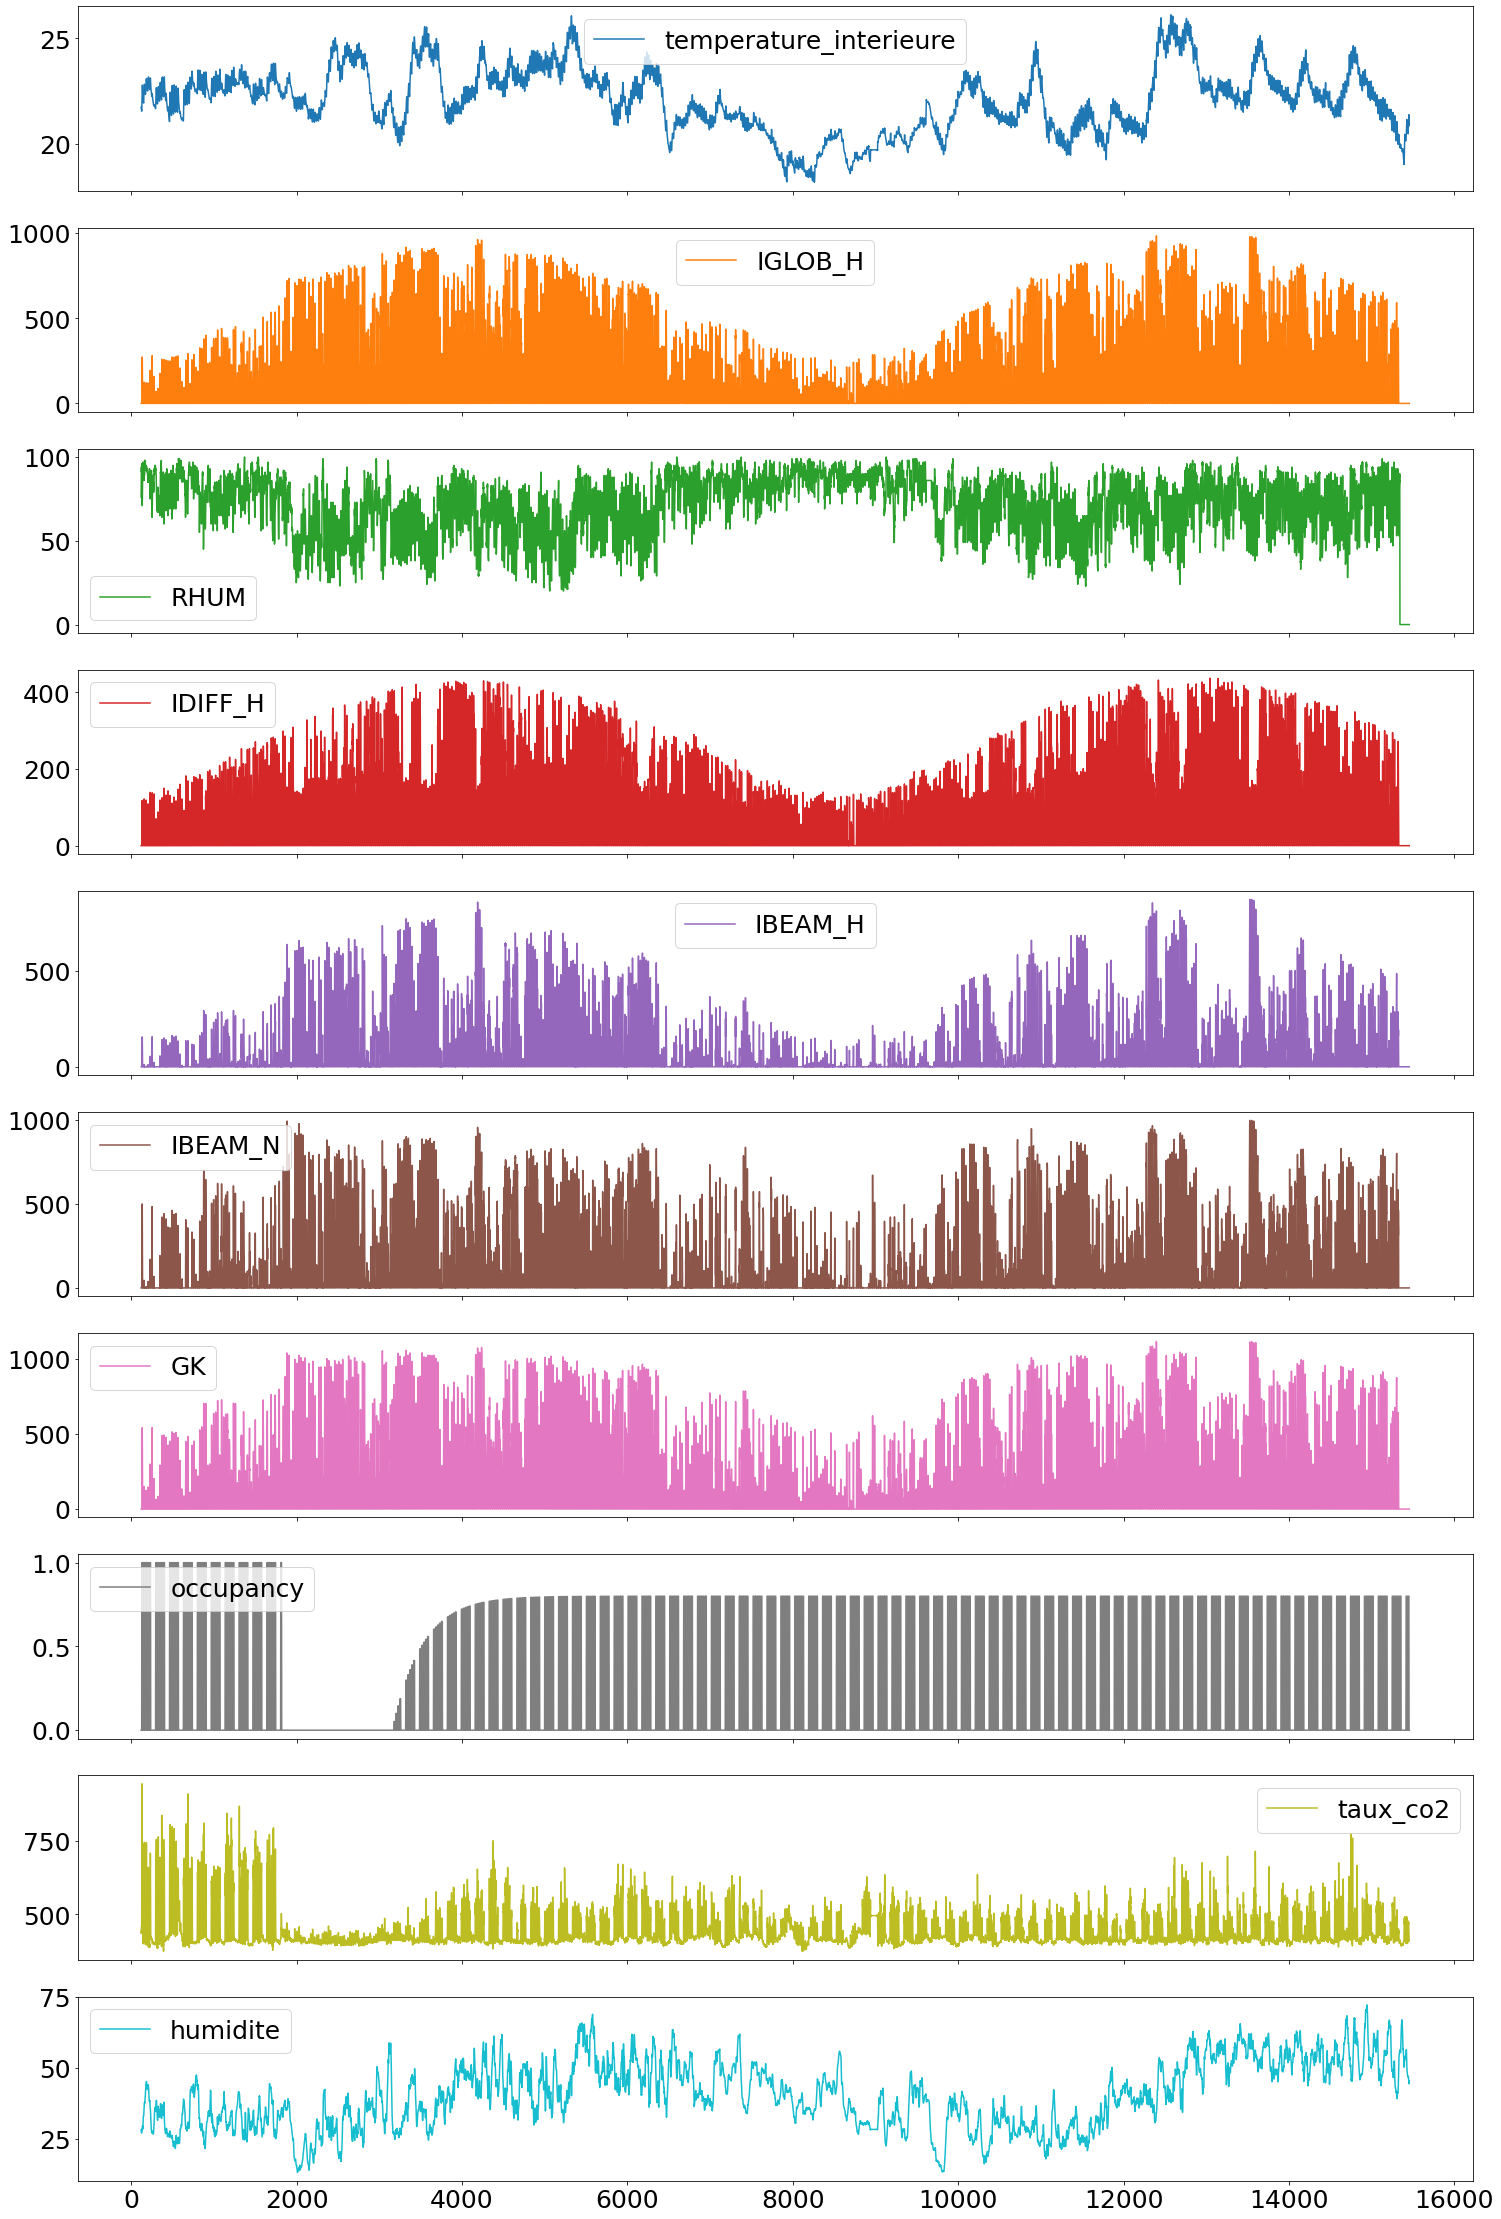

In [5]:
_ = df[[*OzeDataset.input_columns, *OzeDataset.target_columns]].plot(subplots=True, figsize=(25, 40))

### Define dataloaders

In [6]:
dataloader_train = DataLoader(
    OzeDataset(df, T=T, val=False),
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True
)

dataloader_val = DataLoader(
    OzeDataset(df, T=T, val=True),
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False
)

## Model

In [79]:
# We combine a generic input model (3 layered GRU) with a smc layer
class SMCM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.input_model = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=6, dropout=0.3)
        self.smcl = SMCL(input_size=hidden_size,
                         hidden_size=hidden_size,
                         output_size=output_size,
                         n_particles=100,
                        )
        
    def forward(self, u, y=None):
        u_tilde = self.input_model(u)[0]
        y_hat = self.smcl(u_tilde, y)
        return y_hat
    
    def uncertainty_estimation(self, u, y=None, p=0.05, observation_noise=True):
        u_tilde = self.input_model(u)[0]
        return self.smcl.uncertainty_estimation(u_tilde,
                                                  y=y,
                                                  p=p,
                                                  observation_noise=observation_noise)

In [104]:
D_IN = len(OzeDataset.input_columns)
D_OUT = len(OzeDataset.target_columns)

model = SMCM(input_size=D_IN, hidden_size=D_EMB, output_size=D_OUT)

## Traditional training

### Define training steps

In [105]:
class LitClassicModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criteria = torch.nn.MSELoss()
        
        self.hist = []
    
    def training_step(self, batch, batch_idx):
        u, y = batch
        u = u.transpose(0, 1)
        y = y.transpose(0, 1)
        y_hat = self.model(u)
        loss = self.criteria(y, y_hat)
        self.hist.append(loss.item())
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Train

In [106]:
train_model = LitClassicModule(model, lr=3e-3)
trainer = pl.Trainer(max_epochs=EPOCHS, gpus=1, callbacks=[bar])
trainer.fit(train_model, dataloader_train)

# Save pretrain parameters
params_pretrain = copy.deepcopy(model.state_dict())

# Compute cost (default to MSE) mean and variance
losses = compute_cost(model, dataloader_val)
print(f"MSE:\t{losses.mean():.2f} \pm {losses.var():.4f}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Epoch: 1/200:   0%|                                                                                             | 0/200 [00:00<?, ?it/s]
  | Name     | Type    | Params
-------------------------------------
0 | model    | SMCM    | 2.8 K 
1 | criteria | MSELoss | 0     
-------------------------------------
2.8 K     Trainable params
10        Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
/home/mrmojo/Code/these/smcl/.env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
Epoch: 200/200: 100%|██████████████████████████████████████████████████████████

MSE:	0.79 \pm 1.2526


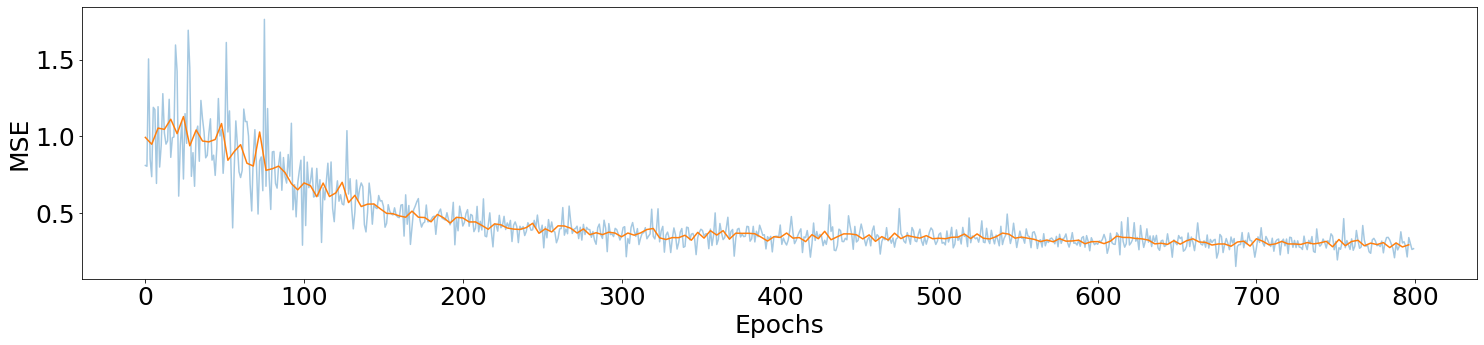

In [107]:
loss = np.array(train_model.hist)
plt.plot(loss, alpha=.4)
plt.plot(np.arange(0, len(loss), len(dataloader_train)), loss.reshape(EPOCHS, len(dataloader_train)).mean(-1))
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

### Plot predictions

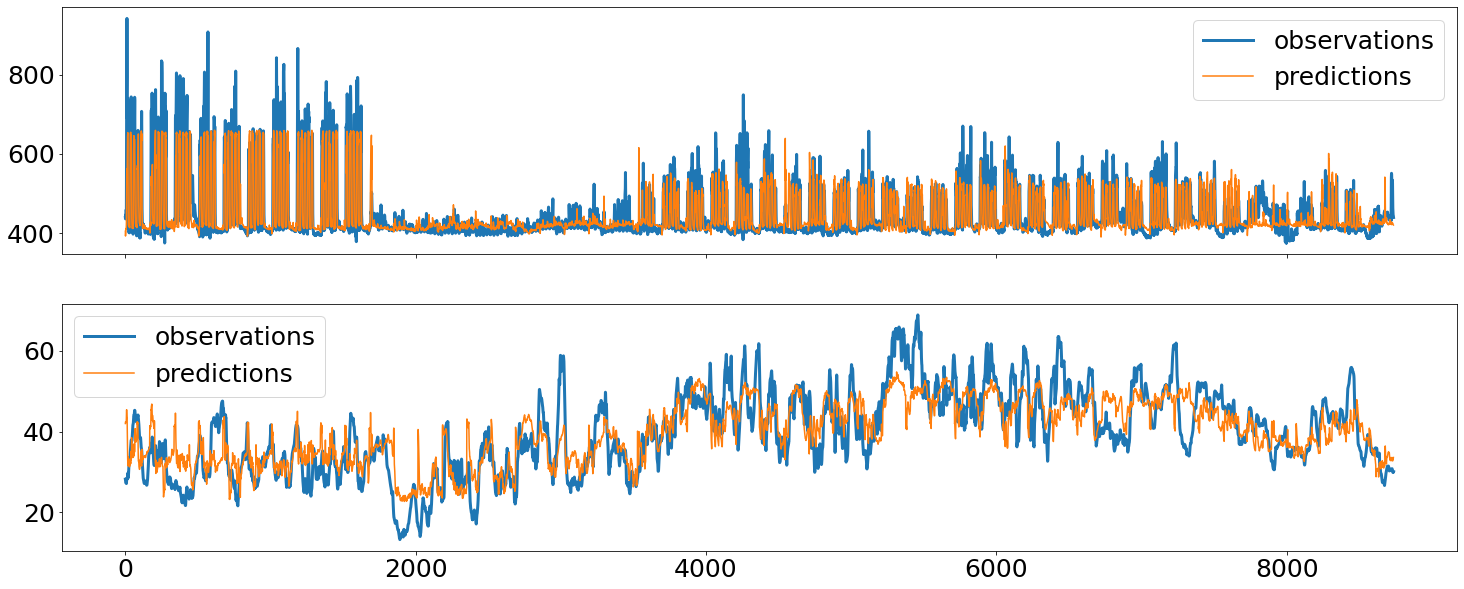

In [108]:
plot_predictions(model, dataloader_train.dataset)

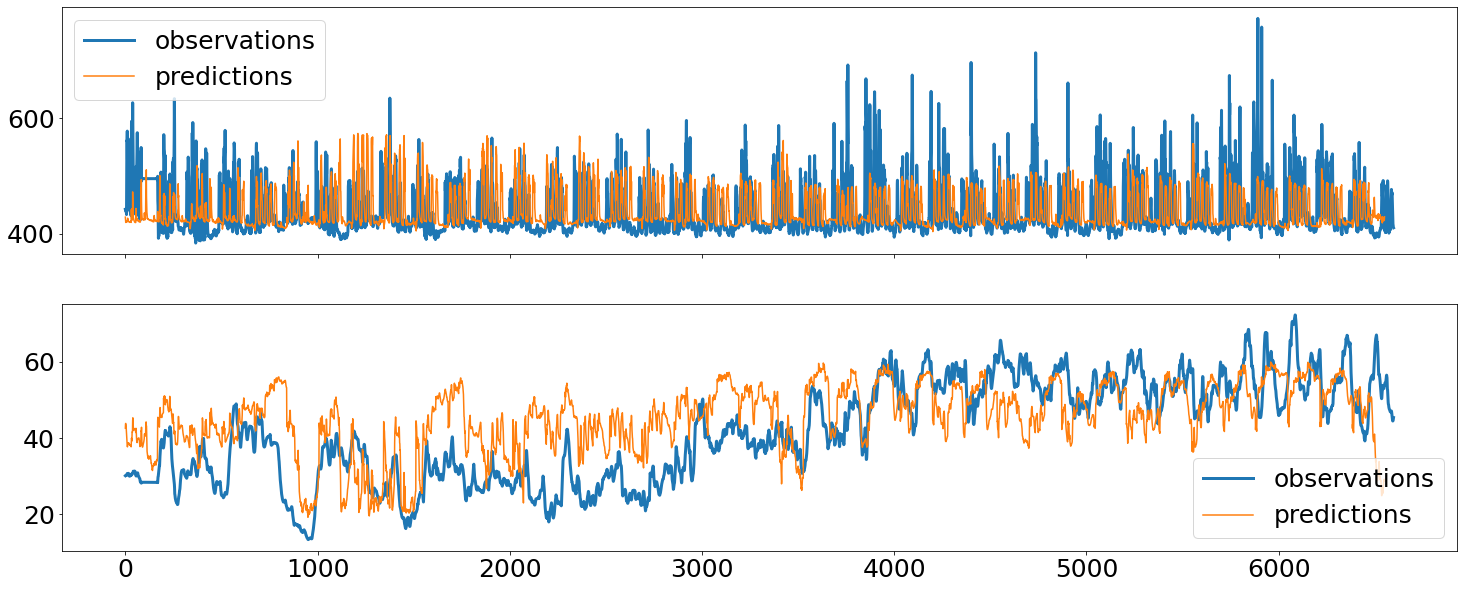

In [109]:
plot_predictions(model, dataloader_val.dataset)

## SMC calibration

### Define training steps

In [110]:
class LitSMCModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
        self.MSE = torch.nn.MSELoss()
        
        
        self._SGD_idx = 1
    
    def training_step(self, batch, batch_idx):
        u, y = batch
        u = u.transpose(0, 1)
        y = y.transpose(0, 1)
        # Forward pass
        self.model(u=u, y=y)
        # Compute loss
        loss = self.model.smcl.compute_cost(y=y)
        # Update Sigma_x
        gamma = 1 / np.sqrt(self._SGD_idx)
        self.model.smcl.sigma_x2 = (1 - gamma)*self.model.smcl.sigma_x2 + gamma*self.model.smcl.compute_sigma_x()
        self.model.smcl.sigma_y2 = (1 - gamma)*self.model.smcl.sigma_y2 + gamma*self.model.smcl.compute_sigma_y(y=y)
        self._SGD_idx += 1
        return loss
   
    def configure_optimizers(self):
        # We only optimize SMCL parameters
        optimizer = torch.optim.Adam(self.model.smcl.parameters(), lr=self.lr)
        return optimizer

### Train

In [ ]:
# Train model
train_model = LitSMCModule(model, lr=3e-3)
trainer = pl.Trainer(max_epochs=EPOCHS_SMCN, gpus=1, callbacks=[bar])
trainer.fit(train_model, dataloader_train)

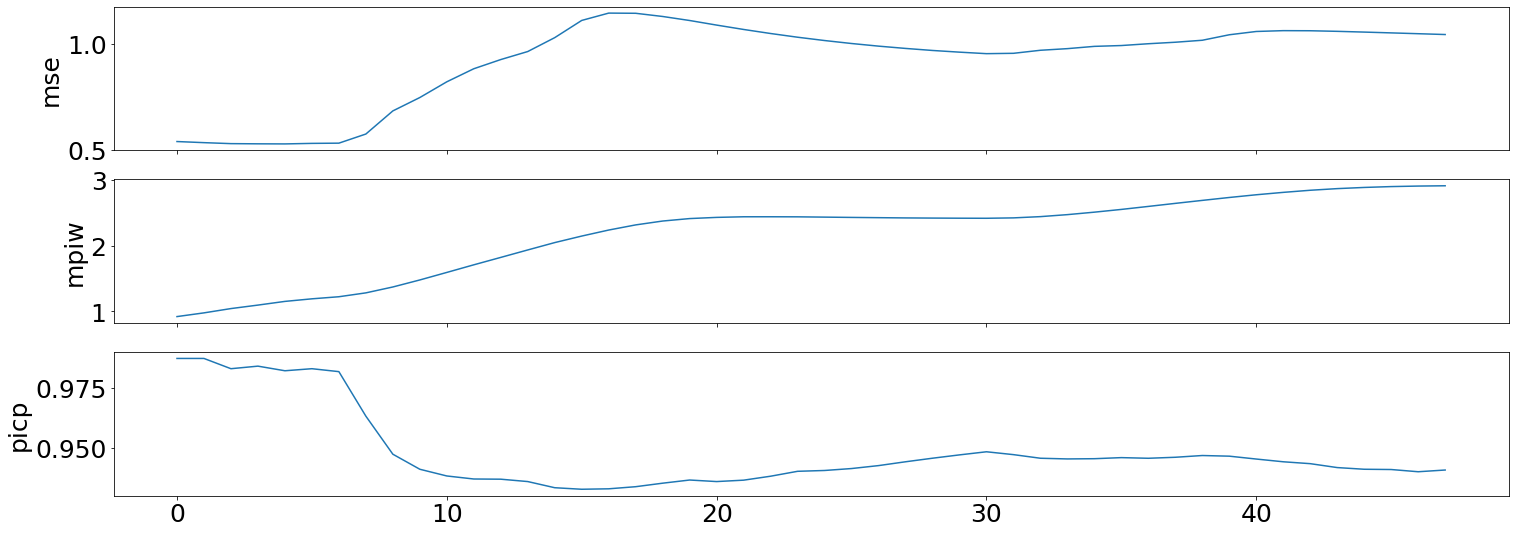

In [112]:
criterias = {
    "mse": model,
    "mpiw": model.uncertainty_estimation,
    "picp": model.uncertainty_estimation,
}

_, axes = plt.subplots(len(criterias), 1, sharex=True, squeeze=False, figsize=(25, 3*len(criterias)))

for (criteria, criteria_model), ax in zip(criterias.items(), axes[:, 0]):
    ax.plot(cumulative_cost(criteria_model, dataloader_val, criteria=criteria, reduction="mean"))
    ax.set_ylabel(criteria)

### Evaluate predictions

In [114]:
# Generate inference sample
idx = np.random.randint(0, len(dataloader_val.dataset))
u, y = dataloader_val.dataset[idx]
u = u.unsqueeze(1)
y = y.unsqueeze(1)

# Set target idx for vialization (0 for CO2 levels)
idx_out = 0

#### Traditional inference with new weights

1.52 \pm 10.3915


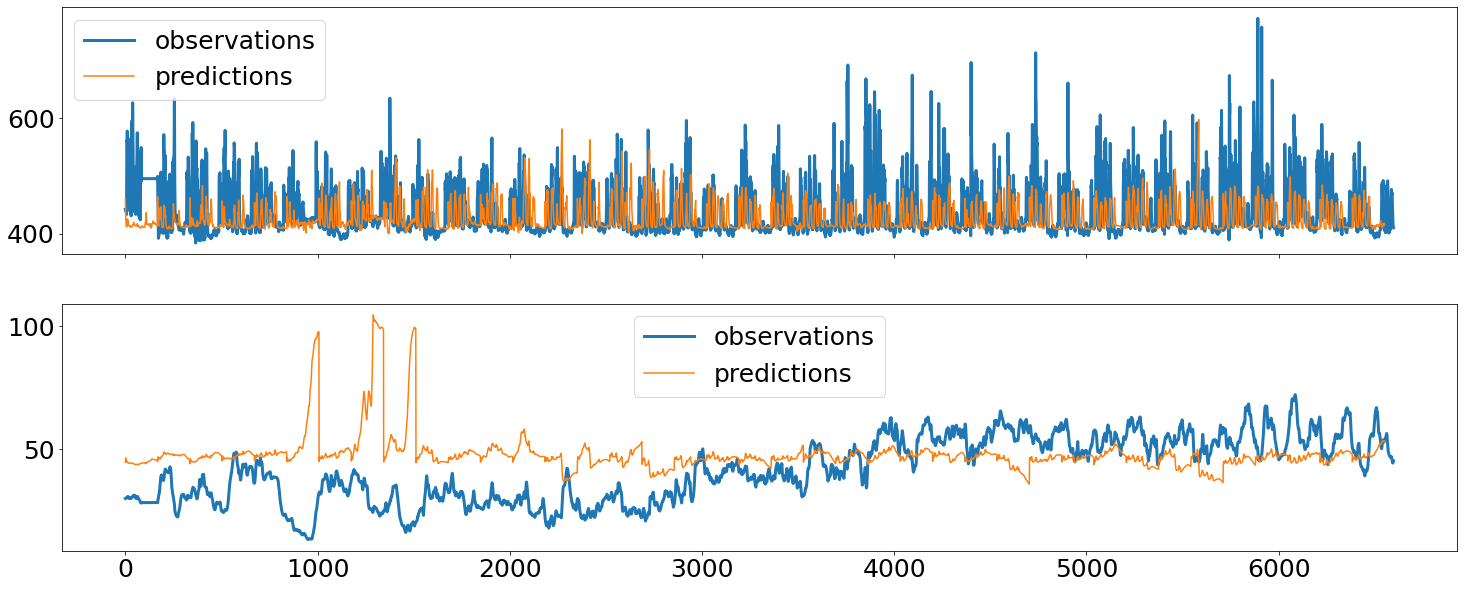

In [119]:
# Plot inference with original model, print cost
model.N=1
plot_predictions(model, dataloader_val.dataset)
losses = compute_cost(model, dataloader_val, criteria="mse")
print(f"{losses.mean():.2f} \pm {losses.var():.4f}")
model.N=N

#### Smoother predictions

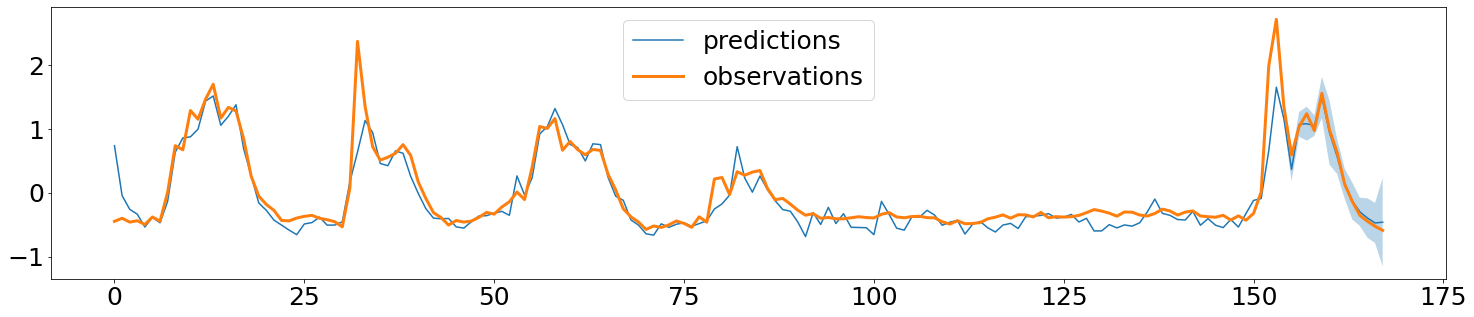

In [120]:
with torch.no_grad():
    netout = model(u=u,
                   y=y)

netout = model.smcl.smooth_pms(netout, model.smcl.I).numpy()

plot_range(netout[:, 0, :, idx_out], label='predictions')
plt.plot(y[:, 0, idx_out], lw=3, label='observations')
plt.legend()
plt.show()

#### Predictions at $t+1$

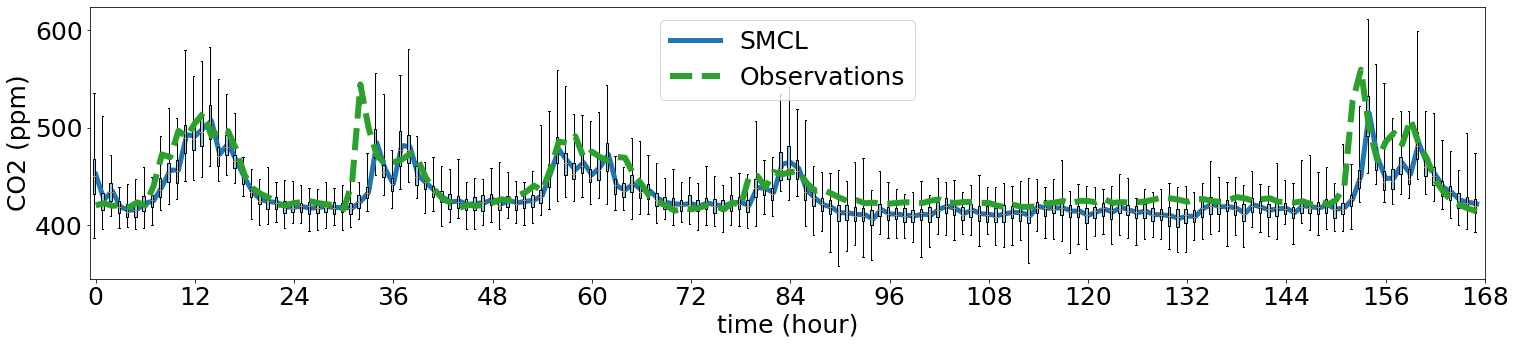

In [121]:
start_day = 0
end_day = start_day+7
day_hide = 0
tick_step = 12
burnin = 0
netout_smc, y_scaled = boxplotprediction(model, dataloader_val, u, y, day_hide=day_hide, burnin=burnin)

netout_smc = netout_smc[24*start_day:24*end_day]
y_scaled = y_scaled[24*start_day:24*end_day]

plt.boxplot(netout_smc.T,
            positions=np.arange(netout_smc.shape[0])-0.2,
            sym="",
            whis=(0, 100), # 95% already selected here
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.plot(netout_smc.mean(-1), lw=5, label='SMCL')


plt.plot(y_scaled, "--", lw=6, label='Observations', zorder=100, color="#2ca02c")

plt.legend()
# plt.xticks(np.arange(burnin, T+1-burnin, 24), np.arange(burnin, T+1-burnin, 24))
plt.xticks(np.arange(0, (end_day - start_day)*24+1, tick_step), np.arange(0, (end_day - start_day)*24+1, tick_step)+start_day*24)
plt.xlabel("time (hour)")
# plt.ylabel("humidity (percent)")
plt.ylabel("CO2 (ppm)")
plt.show()

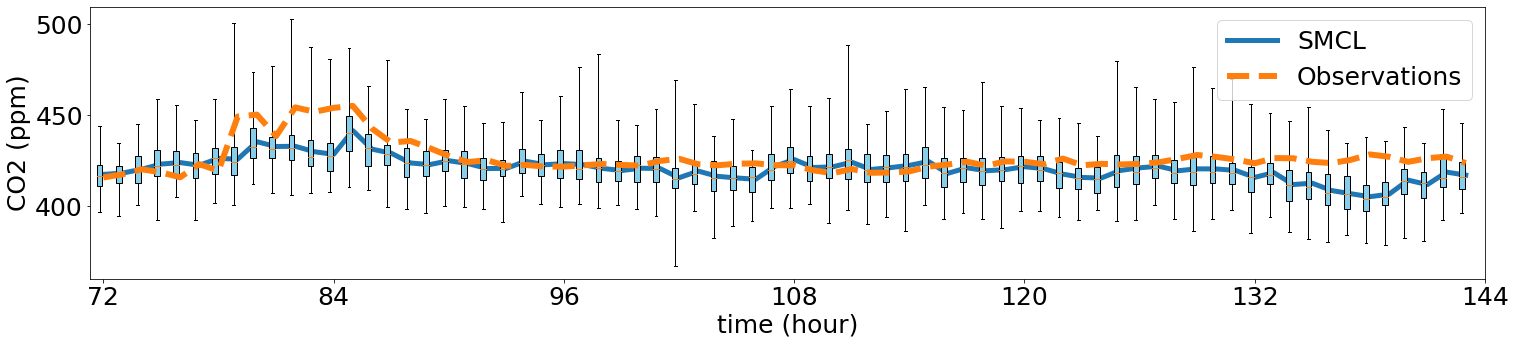

In [122]:
start_day = 3
end_day = start_day+3
day_hide = start_day+1
tick_step = 12

netout_smc, y_scaled = boxplotprediction(model, dataloader_val, u, y, day_hide=day_hide, burnin=0)

netout_smc = netout_smc[24*start_day:24*end_day]
y_scaled = y_scaled[24*start_day:24*end_day]


plt.boxplot(netout_smc.T,
            positions=np.arange(netout_smc.shape[0])-0.2,
            sym="",
            whis=(0, 100), # 95% already selected here
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.plot(netout_smc.mean(-1), lw=5, label='SMCL')


plt.plot(y_scaled, "--", lw=6, label='Observations', zorder=100)

plt.legend()
# plt.xticks(np.arange(burnin, T+1-burnin, 24), np.arange(burnin, T+1-burnin, 24))
plt.xticks(np.arange(0, (end_day - start_day)*24+1, tick_step), np.arange(0, (end_day - start_day)*24+1, tick_step)+start_day*24)
plt.xlabel("time (hour)")
# plt.ylabel("humidity (percent)")
plt.ylabel("CO2 (ppm)")
plt.show()

#### Plot particules with $\alpha \propto \omega$

We plot each trajectory, with a transparancy setting proportionnal to their associated weight. This graph aims at visualizing particle degenerecence.

In [ ]:
with torch.no_grad():
    netout = model(u=u,
                   y=y)

netout = model.smcl.smooth_pms(netout, model.smcl.I)

batch_idx = 0

netout = netout[:, batch_idx, :, idx_out].numpy()
w = model.smcl.w[batch_idx]
# w = torch.softmax(w, dim=0)
w = w.numpy()

# plt.plot(y[:, batch_idx].squeeze().numpy(), '--', lw=3, alpha=0.6, c='green')
for trajectory, weight in zip(netout.T, w):
    plt.plot(trajectory, alpha=weight, c='blue')